<a href="https://colab.research.google.com/github/mateusreisuf/face_encode/blob/master/morph5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade tqdm

     |████████████████████████████████| 71kB 4.8MB/s 
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1


In [ ]:
import os 
os.kill(os.getpid(), 9)

In [1]:
!rm -rf sample_data
!git clone https://github.com/pbaylies/stylegan-encoder

Cloning into 'stylegan-encoder'...
remote: Enumerating objects: 483, done.
remote: Total 483 (delta 0), reused 0 (delta 0), pack-reused 483
Receiving objects: 100% (483/483), 12.75 MiB | 8.30 MiB/s, done.
Resolving deltas: 100% (263/263), done.


In [2]:
cd stylegan-encoder

/content/stylegan-encoder


In [ ]:
ls

adaptive.py                            mona_example.jpg
aligned_images/                        morph/
align_images.py                        Play_with_latent_directions.ipynb
cache/                                 pretrained_example.py*
config.py*                             __pycache__/
data/                                  raw_images/
dataset_tool.py*                       README.md*
dnnlib/                                requirements.txt
encode_images.py                       robust_loss/
encoder/                               run_metrics.py*
ffhq_dataset/                          StyleGAN_Encoder_Tutorial.ipynb
generated_images/                      swa.py
generate_figures.py*                   teaser.png
images/                                train_effnet.py
latent_representations/                training/
Learn_direction_in_latent_space.ipynb  train.py*
LICENSE.txt*                           train_resnet.py
masks/                                 videos/
metrics/


In [ ]:
rm -rf aligned_images raw_images

In [3]:
mkdir aligned_images raw_images

Found 1 images in raw_images
['\\media\\mat\\EA56DA2656D9F2F5\\.Trash-1000\\files\\b.jpg']


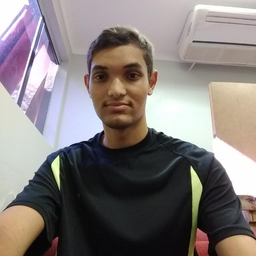

In [4]:
#Colocar imagens na pasta raw_images
from PIL import Image
Image.LOAD_TRUNCATED_IMAGES = True
import os
imgs = sorted(os.listdir('raw_images'))

print("Found %d images in %s" %(len(imgs), 'raw_images'))
if len(imgs) == 0:
  print("Upload images to the \"raw_images\" folder!")
else:
  print(imgs)

for img_path in imgs:
  img = Image.open('raw_images/' + img_path)
  
  w,h = img.size
  rescale_ratio = 256 / min(w,h)
  img = img.resize((int(rescale_ratio*w),int(rescale_ratio*h)), Image.LANCZOS)
  display(img)




In [5]:
%tensorflow_version 1.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 1.x selected.
1.15.2


In [17]:
!python align_images.py raw_images/ aligned_images/ --output_size=1024

Using TensorFlow backend.
Aligning 20200627_205056.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/20200627_205056_01.png
Aligning \media\mat\EA56DA2656D9F2F5\.Trash-1000\files\b.jpg ...
Getting landmarks...
Starting face alignment...
Wrote result aligned_images/\media\mat\EA56DA2656D9F2F5\.Trash-1000\files\b_01.png


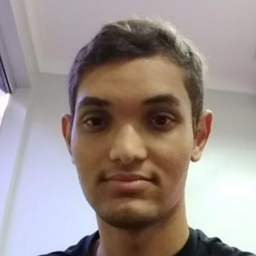

'img 0: \\media\\mat\\EA56DA2656D9F2F5\\.Trash-1000\\files\\b_01.png'

In [7]:
def display_folder_content(folder, res = 256):
  if folder[-1] != '/': folder += '/'
  for i, img_path in enumerate(sorted(os.listdir(folder))):
    if '.png' in img_path:
      display(Image.open(folder+img_path).resize((res,res)), 'img %d: %s' %(i, img_path))
      print('\n')
      
display_folder_content('aligned_images')

In [8]:

!gdown https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
!mkdir data
!mv finetuned_resnet.h5 data
!rm -rf generated_images latent_representations

Downloading...
From: https://drive.google.com/uc?id=1aT59NFy9-bNyXjDuZOTMl0qX0jmZc6Zb
To: /content/stylegan-encoder/finetuned_resnet.h5
330MB [00:05, 59.5MB/s]


In [18]:

!python encode_images.py --optimizer=adam --lr=0.02 --decay_rate=0.95 --decay_steps=6 --use_l1_penalty=0.3 --face_mask=True --iterations=400 --early_stopping=True --early_stopping_threshold=0.05 --average_best_loss=0.5 --use_lpips_loss=0 --use_discriminator_loss=0 --output_video=True aligned_images/ generated_images/ latent_representations/





Using TensorFlow backend.










Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where




Instructions for updating:
If using Keras pass *_constraint arguments to layers.

  0% 0/2 [00:00<?, ?it/s]WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:431: The name tf.is_variable_initialized is deprecated. Please use tf.compat.v1.is_variable_initialized instead.


Loading mask masks/\media\mat\EA56DA2656D9F2F5\.Trash-1000\files\b_01.png
Loading ResNet Model:

  0% 0/400 [00:00<?, ?it/s]WARNING:tensorflow:From /content/stylegan-encoder/encoder/perceptual_model.py:292: The name tf.train.AdamOptimizer is deprecated. Please use tf.compat.v1.train.AdamOptimizer instead.

Instructions for updating:
This op will be removed after the deprecation date. Please switch to tf.sets.difference().

\media\mat\EA56DA2656D9F2F5\.Trash-1000\files\b_01: loss 136.7502; lr 0.0200:   0% 0/400 [00:04<?, ?it/s]
\media\ma

In [10]:
!mkdir cache

In [16]:
import dnnlib, pickle
import dnnlib.tflib as tflib
tflib.init_tf()
synthesis_kwargs = dict(output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True), minibatch_size=1)

model_dir = 'cache/'
model_path = [model_dir+f for f in os.listdir(model_dir) if 'stylegan-ffhq' in f][0]
print("Loading StyleGAN model from %s..." %model_path)

with dnnlib.util.open_url(model_path) as f:
  generator_network, discriminator_network, averaged_generator_network = pickle.load(f)
  
print("StyleGAN loaded & ready for sampling!")









Loading StyleGAN model from cache/263e666dc20e26dcbfa514733c1d1f81_karras2019stylegan-ffhq-1024x1024.pkl...







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
StyleGAN loaded & ready for sampling!


In [19]:
def generate_images(generator, latent_vector, z = True):
    batch_size = latent_vector.shape[0]
    
    if z: #Start from z: run the full generator network
        return generator.run(latent_vector.reshape((batch_size, 512)), None, randomize_noise=False, **synthesis_kwargs)
    else: #Start from w: skip the mapping network
        return generator.components.synthesis.run(latent_vector.reshape((batch_size, 18, 512)), randomize_noise=False, **synthesis_kwargs)



In [20]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

import numpy as np
def plot_imgs(model, rows, columns,w):
  a=0
  alpha=0
  step=1.0/len(w)
  print(len(w))
  for i in range(rows):
    f, axarr = plt.subplots(1,columns, figsize = (20,8))
    for j in range(columns):
      img = generate_images(model, w[a],z = False)[0]
      a+=1
      axarr[j].imshow(img)
      axarr[j].axis('off')
      axarr[j].set_title('Alpha: %f' %float(alpha))
      alpha+=step
      img=Image.fromarray(img)
      img.save('./morph/'+str(a)+'.png')
    plt.show()

In [13]:
!mkdir images morph results

In [ ]:


import numpy as np

from PIL import Image

i=0
for f in sorted(os.listdir('latent_representations')):
  w = np.load('latent_representations/' + f).reshape((1,18,-1))
  img = generate_images(averaged_generator_network, w, z = False)[0]
  print(img.shape)
  
  im = Image.fromarray(img)
  im.save('images/'+str(i)+'.png')
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  
  plt.show()
  i+=1





IsADirectoryError: ignored

In [ ]:
from PIL import Image
num_batch=40
n=0
for i in range(num_batch):
  img = generate_images(averaged_generator_network,np.random.randn(16,512),z=True)
  for j in range(img.shape[0]):
    im=Image.fromarray(img[j])
    im.save('./results/'+str(n)+'.png')
    print(n)
    n+=1
  print('batch',i)

In [ ]:
!pip install keras_vggface


In [ ]:
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import glob
import numpy as np
from keras.preprocessing import image

a=glob.glob('./results/*.png')
images=[]
for i in range(len(a)):
  im=image.load_img(a[i],target_size=(224,224))
  im=image.img_to_array(im)
  im = np.expand_dims(im, axis=0)
  im = preprocess_input(im, version=2)
  images.append(im)
images=np.array(images)
images=images.reshape(images.shape[0],224,224,3)
print(images.shape)
model = VGGFace(model='resnet50',include_top=False,input_shape=(224,224,3))

vectors=model.predict(images)
print(vectors.shape)
vectors=vectors.reshape(vectors.shape[0],2048)
np.save('./vgg.npy',vectors)






(2560, 224, 224, 3)
(2560, 1, 1, 2048)


0.5853646099567413
724
./results/2416.png


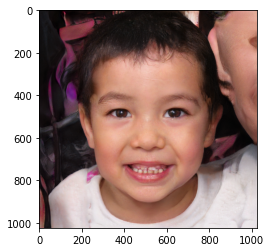

0.6005723774433136
599
./results/1357.png


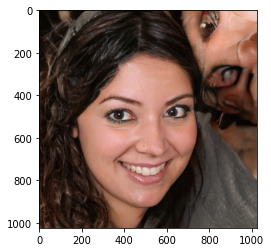

In [ ]:
from keras.preprocessing import image
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
import numpy as np
import glob
from scipy.spatial.distance import cosine

def euclidean(y,x):
  return np.linalg.norm(y-x)

a = glob.glob('./aligned_images/*png')
im = image.load_img(a[0],target_size=(224,224))
im = image.img_to_array(im)
im = np.expand_dims(im, axis=0)
im = preprocess_input(im, version=2)

model = VGGFace(model='resnet50',include_top=False,input_shape=(224,224,3))

im = model.predict(im)
im = im.reshape(1,2048)

b=np.load('./vgg.npy')
min=99999
pos=0
for i in range(b.shape[0]):
  x=cosine(im,b[i])
  if(x<min):
    min2 = min
    pos2 = pos
    min = x
    pos = i

print(min)
print(pos)

c=glob.glob('./results/*.png')
print(c[pos])

img=image.load_img(c[pos])
plt.imshow(img)
plt.imsave('./raw_images/test.png',np.array(img))
plt.show()


print(min2)
print(pos2)

c=glob.glob('./results/*.png')
print(c[pos2])

img=image.load_img(c[pos2])
plt.imshow(img)
plt.imsave('./raw_images/test2.png',np.array(img))
plt.show()





In [21]:
def morph(W1 , W2,model, num_images):
  vetora=np.load(W1).reshape(1,18,-1)
  vetorb=np.load(W2).reshape(1,18,-1)
  n=1.0/num_images
  alpha=0
  l=[]
  for i in range(num_images):
    w=alpha*vetora +(1-alpha)*vetorb
    #img=generate_images(averaged_generator_network, w, z = False)[0]
    l.append(w)
    alpha+=n
    
  plot_imgs(averaged_generator_network,int(num_images/5),5,l)
  return



['./latent_representations/20200627_205056_01.npy', './latent_representations/\\media\\mat\\EA56DA2656D9F2F5\\.Trash-1000\\files\\b_01.npy']
30


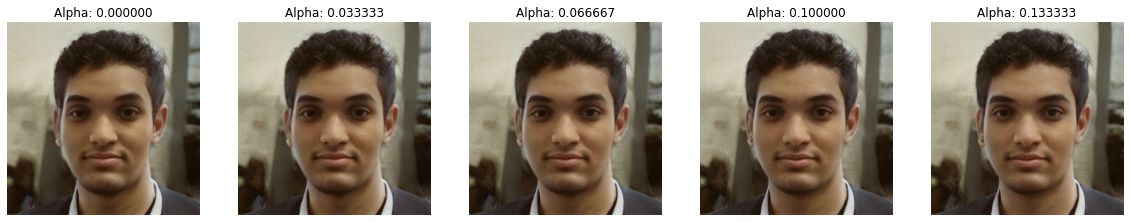

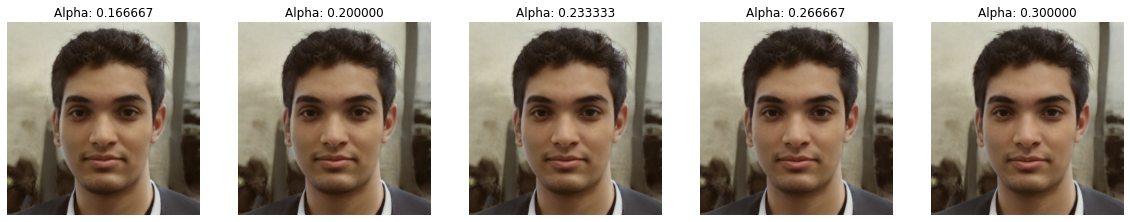

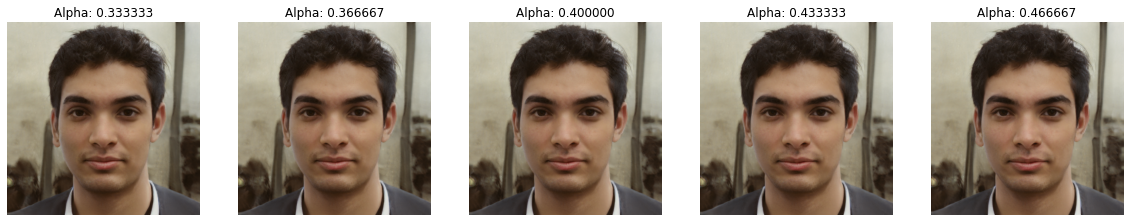

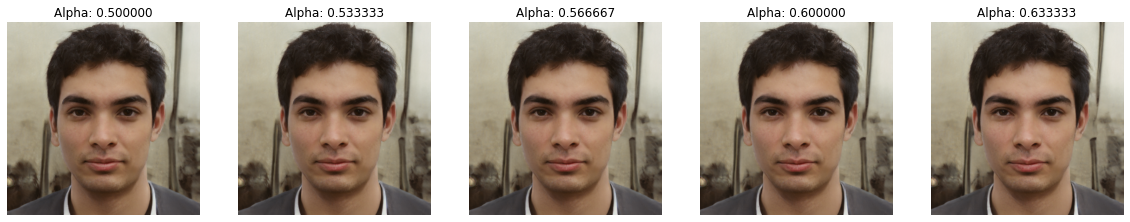

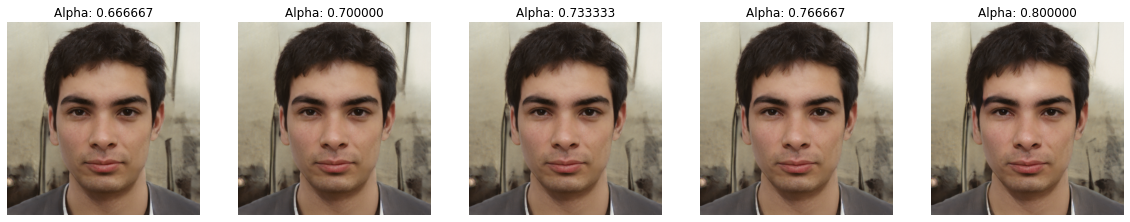

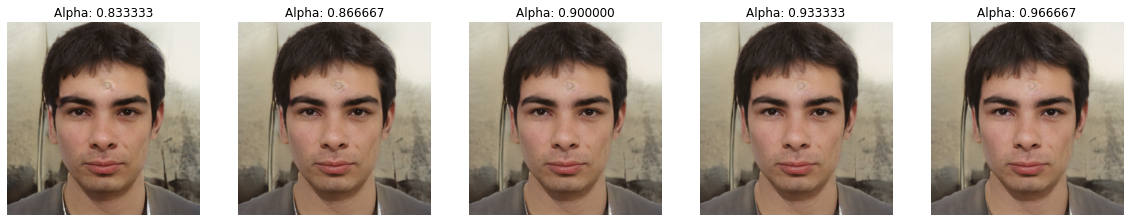

In [24]:
#Usar quando quiser reconstruir images a partir dos vetores na pasta latent_representations
'''
!mkdir images
import numpy as np
from PIL import Image
import glob

h=9
a=glob.glob('./latent_representations/*.npy')
for i in range(len(a)):
  w=np.load(a[i]).reshape((1,18,-1))
  img=generate_images(averaged_generator_network,w,z=False)[0]
  im = Image.fromarray(img)
  im.save('./images/'+str(h)+".png")
  plt.imshow(img)
  plt.axis('off')
  plt.title("Generated image from %s" %f)
  plt.show()
  h+=1
'''
# morph
import numpy as np
from PIL import Image
import glob

a=glob.glob('./latent_representations/*.npy')
print(a)

morph(a[0],a[1],averaged_generator_network,50)







